In [1]:
import os, sys, glob

from BreyoSpec import BreyoSpec
import numpy as np
import matplotlib.pyplot as plt

from specutils.analysis import snr
from specutils import Spectrum1D
from astropy import units as u
from astropy.nddata import NDUncertainty

import seaborn as sb
sb.set(context='talk', palette='Set1', style='whitegrid')

In [2]:
# define some useful functions
def combSpec(spec1, spec2, radFrac=1, w=0.01, fracAtm = 0.25):
    '''
    Combine spectrum and simulate noise
    
    spec1 and spec2 are BreyoSpec objects
    w [float] :  number between 0 and 1 defining how noisy the combined spectrum should be
    radFrac [float] : fraction of exoplanet radius to host star radius
    fracAtm [float] : amount of exoplanets atmosphere that is transmissible (percent in decimal form)
    return: subtracted spectrum
    '''
    
    # determine factor to mulitply spec2.flux by
    factor = (1-(1-fracAtm)**2)*(radFrac)**2
    
    # combine flux with that factor
    combFlux = spec1.flux + factor*spec2.flux # add spectra
    combFluxNoisy = combFlux+w*np.random.normal(combFlux) # simulate noise
    
    return spec1.wave, combFluxNoisy

def plotExo(exowave, exoflux, jupwave, jupflux, ax=None, lw=3, **kwargs):
    
    if not ax:
        fig, ax = plt.subplots(figsize=(16,6))
    
    ax.plot(exowave, exoflux, linewidth=lw/2, **kwargs)
    ax.plot(jupwave, jupflux-np.median(jupflux), label='Jupiter', linewidth=lw/2)
    ax.axvline( 6562.8, color='k', linestyle='--', alpha=0.5, linewidth=lw) #label=r'H$\alpha$'
    ax.axvline( 4861.3, color='k', linestyle='--', alpha=0.5, linewidth=lw) # label=r'H$\beta$',
    ax.axvline( 4340.4, color='k', linestyle='--', label='Balmer Lines', alpha=0.5, linewidth=lw)
    ax.axvline( 6190, linestyle='--', color='darkgoldenrod', label=r'Methane', linewidth=lw) # alpha=0.5,

    ax.set_xlabel('Wavelength [$\AA$]', fontsize=16)
    ax.set_ylabel('Flux [$e^-$]', fontsize=16)
    #ax.grid()

In [3]:
hostDir = '/home/ubuntu/Documents/ObsAstro/Data/postTransitOutput/'
hostPaths = glob.glob(hostDir+"*")

jupPath = '/home/ubuntu/Documents/ObsAstro/Data/Jupiter_20211109T005343.fit'

In [4]:
hostSpec = BreyoSpec(hostPaths) # host star spectrum
jupSpec = BreyoSpec(jupPath)

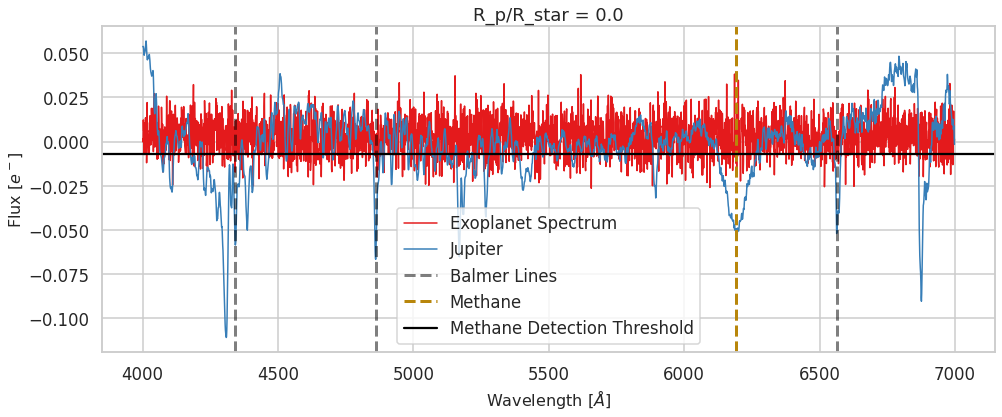

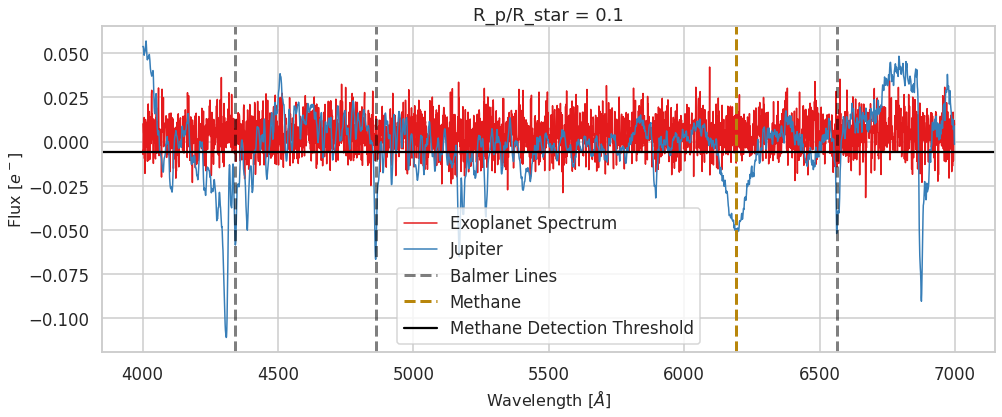

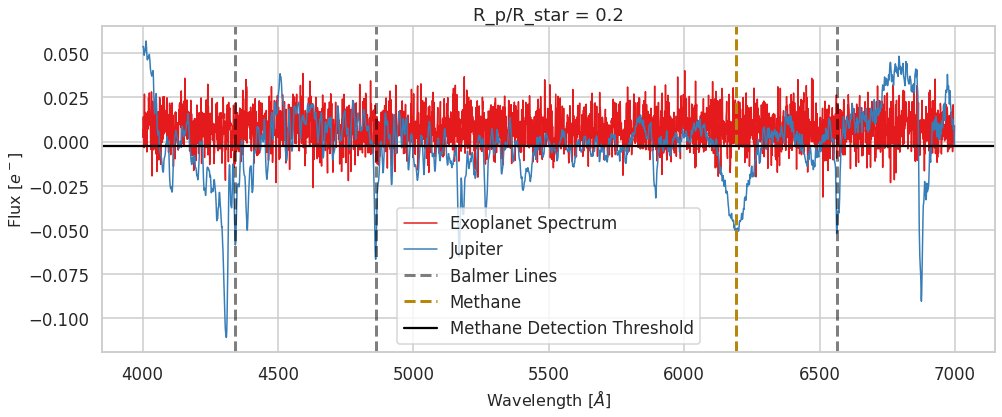

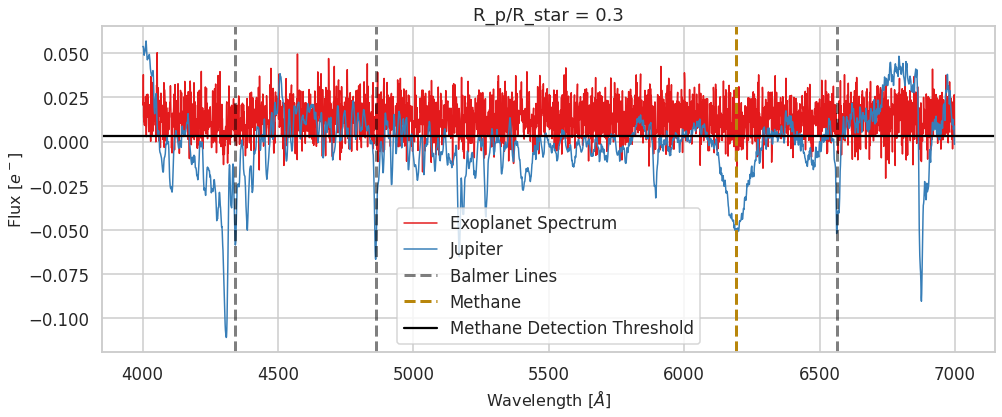

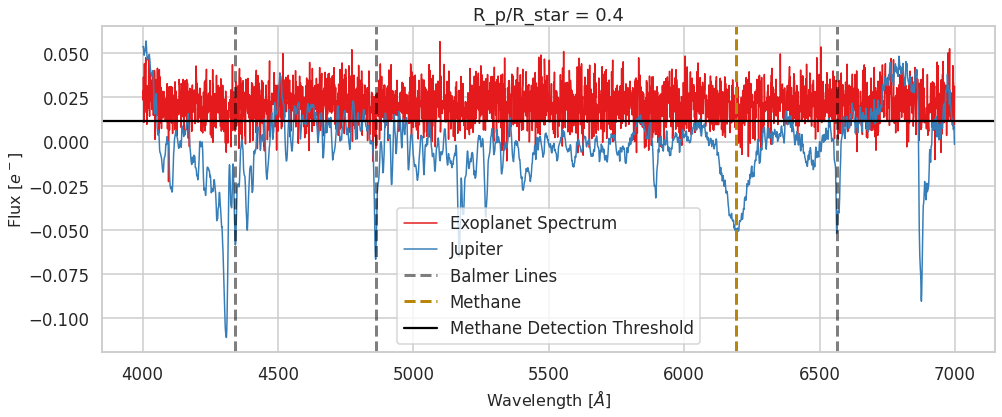

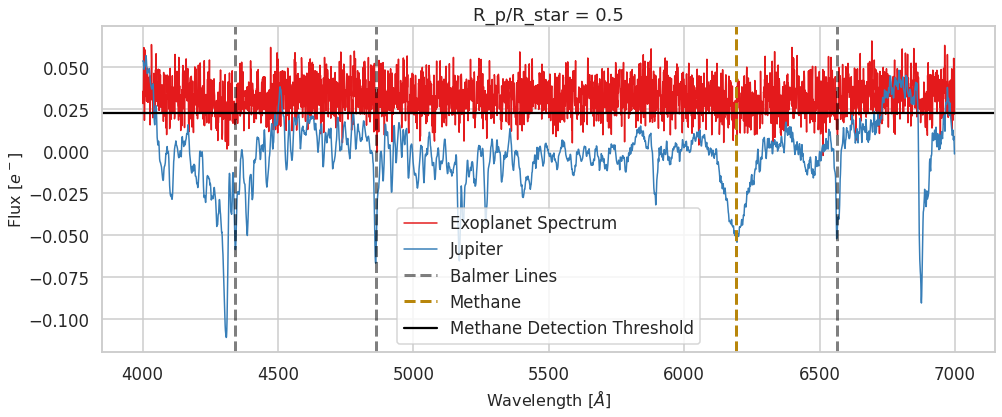

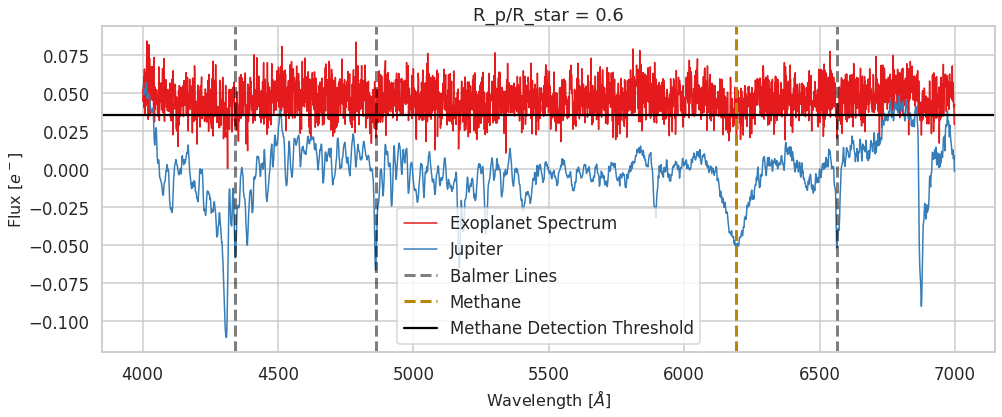

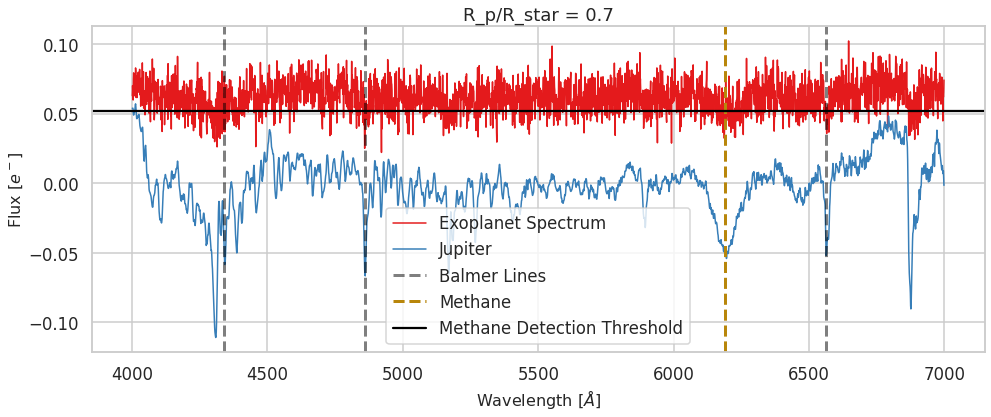

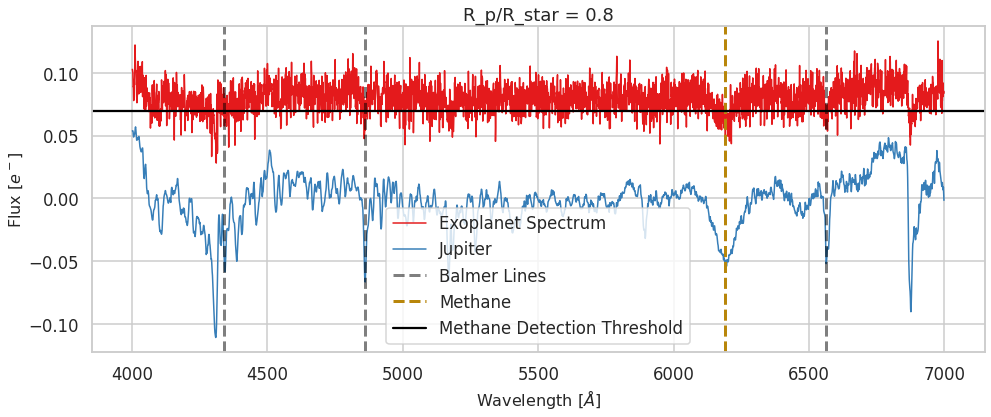

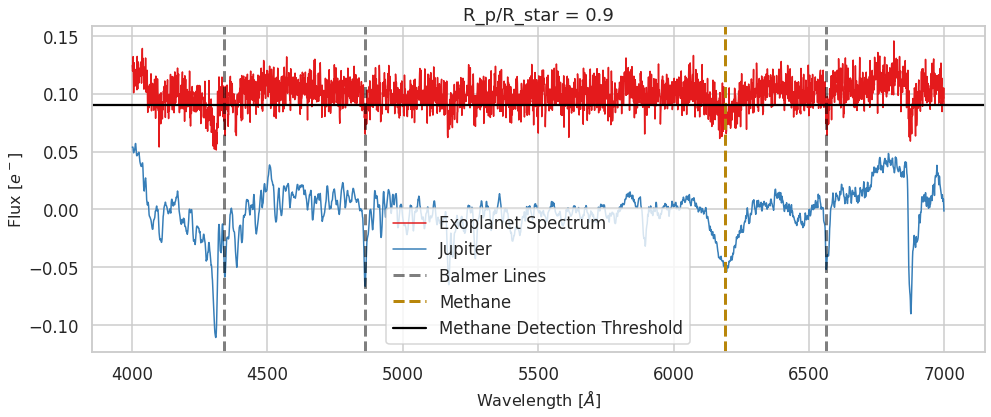

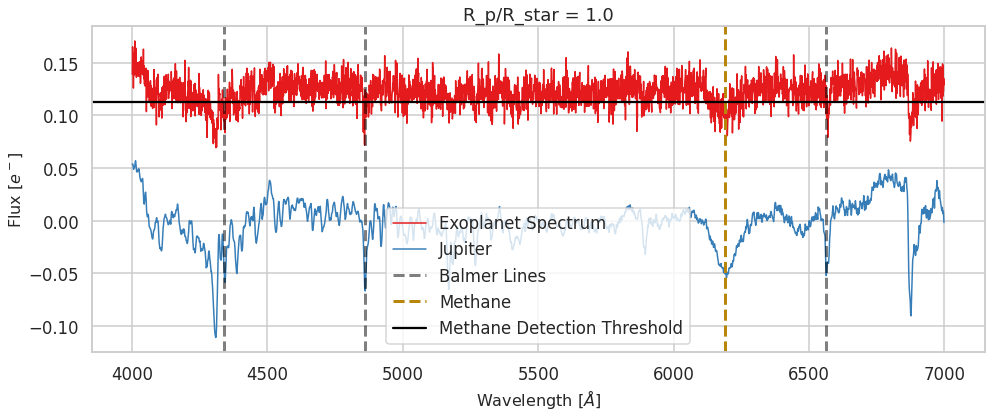

In [35]:
# Create bunch of spectrum with different radii ratios

n = 11

radiusFrac = np.linspace(0,1,n)

for rf in radiusFrac:
    wave, flux = combSpec(hostSpec, jupSpec, radFrac=rf, fracAtm=0.25)
    
    exoFlux = flux - hostSpec.flux
    
    fig, ax = plt.subplots(figsize=(16,6))
    plotExo(wave, exoFlux, jupSpec.wave, jupSpec.flux, ax=ax, label='Exoplanet Spectrum', lw=3)
    
    ax.set_title(f'R_p/R_star = {rf:.1f}')
    #ax.axhline(np.median(exoFlux), color='k')
    ax.axhline(np.median(exoFlux)-0.01, color='k', label='Methane Detection Threshold')
    ax.legend(loc='lower center')

In [24]:
plot = False
n = 1000 # number of radii fractions to test
m = 20 # number of atmosphere transmissibilities to test

radiusFrac = np.linspace(0,1,n)
fracAtms = np.linspace(0,1,m)
percents = []


for fa in fracAtms:
    temp = []
    for rf in radiusFrac:
        wave, flux = combSpec(hostSpec, jupSpec, radFrac=rf, fracAtm=fa)

        exoFlux = flux - hostSpec.flux

        if plot:
            fig, ax = plt.subplots(figsize=(16,6))
            plotExo(wave, exoFlux, jupSpec.wave, jupSpec.flux, ax=ax, label='Exoplanet Spectrum')
            ax.legend()
            ax.set_title(f'R_p/R_star = {rf}')
            ax.axhline(np.median(exoFlux), color='k')

        methaneWave = 6190
        whereMethane = np.where((wave > methaneWave-10) * (wave < methaneWave+10))[0]

        noise = np.median(exoFlux)
        methaneMed = np.median(exoFlux[whereMethane])

        percentAboveNoise = np.abs((noise - methaneMed))
        temp.append(percentAboveNoise)
        
    percents.append(temp)

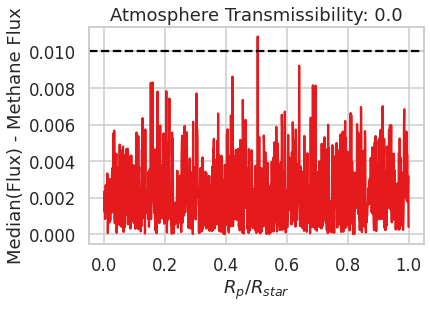

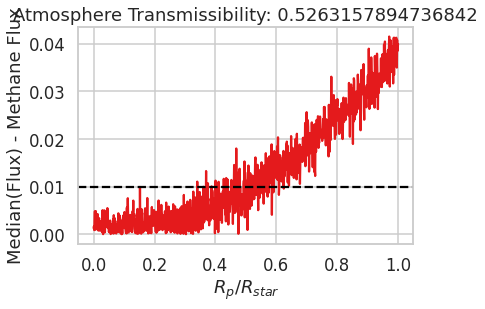

In [25]:
for ii in range(len(fracAtms)):
    if ii % 10 == 0:
        plt.figure()
        plt.plot(radiusFrac, percents[ii])
        plt.xlabel('$R_p / R_{star}$')
        plt.ylabel('Median(Flux) - Methane Flux')
        plt.title(f'Atmosphere Transmissibility: {fracAtms[ii]}')
        plt.axhline(0.01, color='k', linestyle='--')

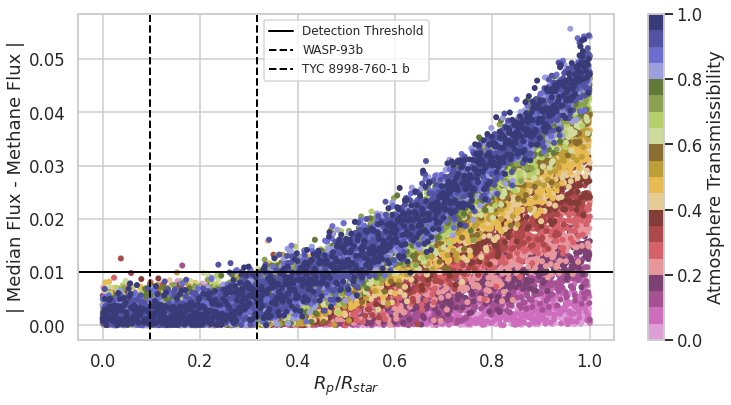

In [31]:
radiusFrac_ndim = np.array([radiusFrac for i in range(m)])
colorRelative = np.array([np.array([val]*n) for val in fracAtms])

# cite: https://ui.adsabs.harvard.edu/abs/2016MNRAS.463.3276H/abstract

def ratioFrac(rStar, rPlanet):
    '''
    rStar : units of R_sun
    rPlanet : units of R_J
    '''
    Rj = 0.10045 # Rsun
    return rPlanet*Rj / rStar

R93 = 1.524 # Rsun
R93b = 1.461 # Rj

plt.figure(figsize=(12,6))

plt.scatter(radiusFrac_ndim, np.array(percents), c=colorRelative, cmap='tab20b_r', marker='.') #cividis_r
plt.xlabel('$R_p / R_{star}$')
plt.ylabel('| Median Flux - Methane Flux |')
plt.axhline(0.01, color='k', linestyle='-', linewidth=2, label='Detection Threshold')
plt.axvline(ratioFrac(R93, R93b), color='k', linestyle='--', linewidth=2, label='WASP-93b')
plt.axvline(ratioFrac(0.95, 3), color='k', linestyle='--', linewidth=2, label='TYC 8998-760-1 b')
plt.colorbar(label='Atmosphere Transmissibility')
plt.legend(fontsize=12);